# Basic experiment section

Here we expand successful classification of 2 classes to ten classes. 

## Data preparation

Here we just use data preparation module to get sample and target and extract 10 desired classes from them. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
! pip3 install torchinfo
from torchinfo import summary
import torchvision
import torch 
from IPython.display import clear_output
from torch.utils.data import Dataset, random_split
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from collections import defaultdict
import time


In [ ]:
import os
import shutil

import glob
import requests

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 18.6MB/s 
     |████████████████████████████████| 3.3MB 48.9MB/s 
     |████████████████████████████████| 870kB 50.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=f27142d2ddb3b97fa6ffe9c865e7fb7a5c67b233718a42a92f2771dfc58f5bfc
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 19.3MB/s 


In [ ]:
from transformers import AlbertTokenizer, XLNetTokenizer, AutoModel, pipeline
import re
import os
import requests
from tqdm.auto import tqdm

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained("Rostlab/prot_albert", do_lower_case=False )
#tokenizer = XLNetTokenizer.from_pretrained("Rostlab/prot_xlnet", do_lower_case=False)



In [ ]:
model = AutoModel.from_pretrained("Rostlab/prot_albert")
#model = AutoModel.from_pretrained("Rostlab/prot_xlnet")

In [ ]:
fe = pipeline('feature-extraction', model=model, tokenizer=tokenizer,device=0)

In [ ]:
seq_data = pd.read_csv("/content/drive/MyDrive/m1p/seq_to_fold.csv")
seq_data = seq_data[["FOLD", "sequence"]]
seq_data.head()

,FOLD,sequence
0,1400,DMKRQQRFFRIPFIRPADQYKDPQNKKKGWWYAHFDGPWIARQMEL...
1,1400,RQREIEMNRQQRFFRIPFIRPADQYKDPQSKKKGWWYAHFDGPWIA...
2,11,MKIKVALLDKDKEYLDRLTGVFNTKYADKLEVYSFTDEKNAIESVK...
3,11,QTPHILIVEDELVTRNTLKSIFEAEGYDVFEATDGAEMHQILSEYD...
4,11,SFERVFGKRVIILGGGALVSQVAIGAISEADRHNLRGERISVDTMP...


## Choosing ten relatively balanced classes.

This section is devoted to narrowing the dataset to ten classes.

In [ ]:
def print_fold_info(fold_id, data):
  """
  Plots distribution of sequence lengths in fold as well as number of sequences.
  """
  fold_data = data[data['FOLD'] == fold_id]
  sequences = fold_data.loc[:, "sequence"]
  lengths = sequences.apply(lambda x:  len(x))
  plt.figure(figsize = (9, 6))
  plt.hist(lengths, bins = 15, density=False, facecolor='purple', alpha=0.55)
  plt.xlabel('Length')
  plt.ylabel('Number of elements')
  plt.title(f'Histogram of sequence lengths for fold {fold_id}')
  plt.grid(True)
  plt.show()
  print(f"Number of elements in fold = {len(sequences)}")

def compare_folds(fold_id, fold_other, data):
  """
  Plots distribution of sequence lengths in fold as well as number of sequences
  for two given folds.
  """
  fold_data1 = data[data['FOLD'] == fold_id]
  sequences1 = fold_data1.loc[:, "sequence"]
  lengths1 = sequences1.apply(lambda x:  len(x))
  fold_data2 = data[data['FOLD'] == fold_other]
  sequences2 = fold_data2.loc[:, "sequence"]
  lengths2 = sequences2.apply(lambda x:  len(x))
  plt.figure(figsize = (9, 6))
  plt.hist(lengths1, bins = 15, density=True, facecolor='purple', alpha=0.5, 
           label = f"fold_id = {fold_id}")
  plt.hist(lengths2, bins = 15, density=True, facecolor='green', alpha=0.5, 
           label = f"fold_id = {fold_other}")
  plt.xlabel('Length')
  plt.ylabel('Density')
  plt.title(f'Comparison of two given folds')
  plt.grid(True)
  plt.legend()
  plt.show()
  print(f"Number of elements in fold {fold_id} = {len(sequences1)}, in" 
  f" fold {fold_other} = {len(sequences2)}")


We will examine classes with the number of proteins from 80 to 120 and choose 10 relatively balanced ones among them. 

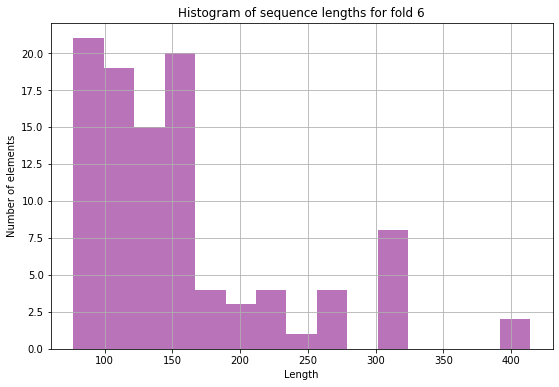

Number of elements in fold = 101


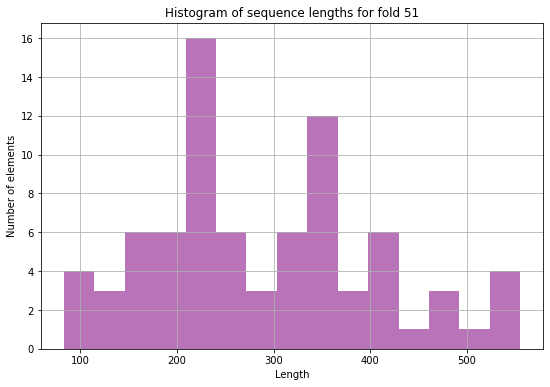

Number of elements in fold = 80


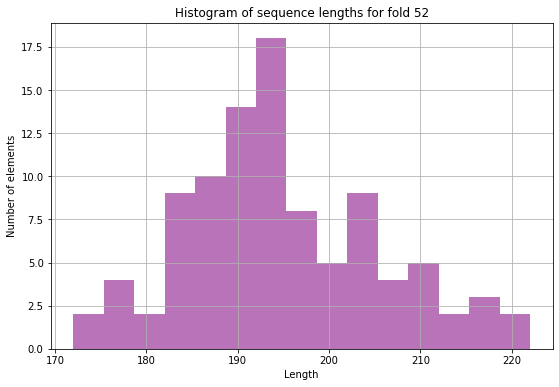

Number of elements in fold = 97


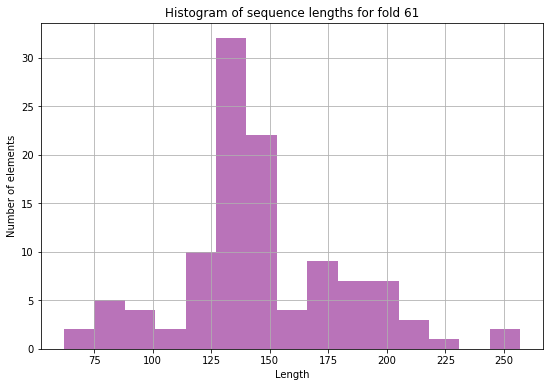

Number of elements in fold = 110


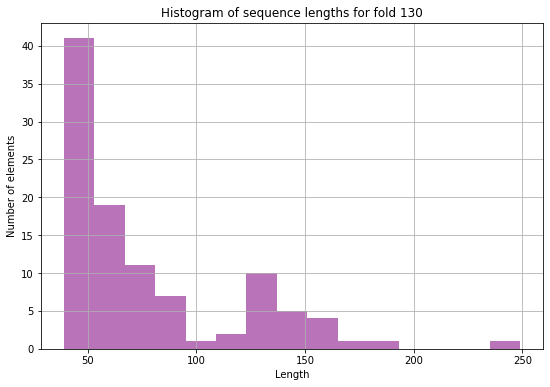

Number of elements in fold = 103


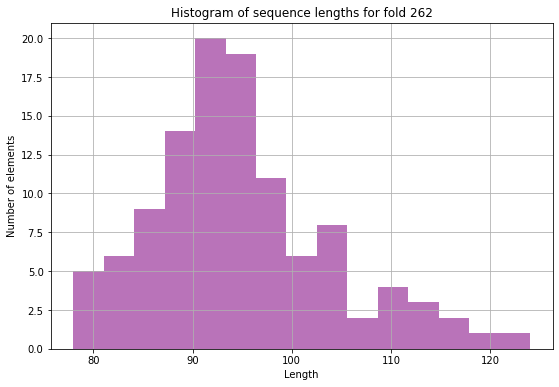

Number of elements in fold = 111


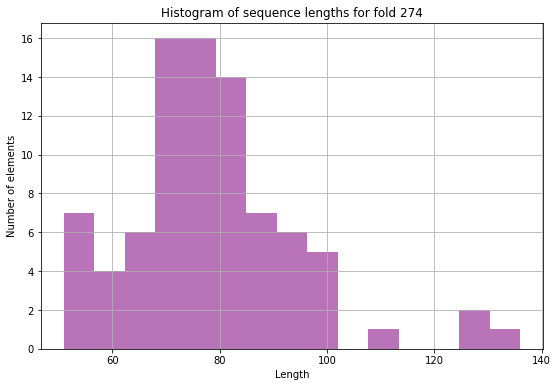

Number of elements in fold = 85


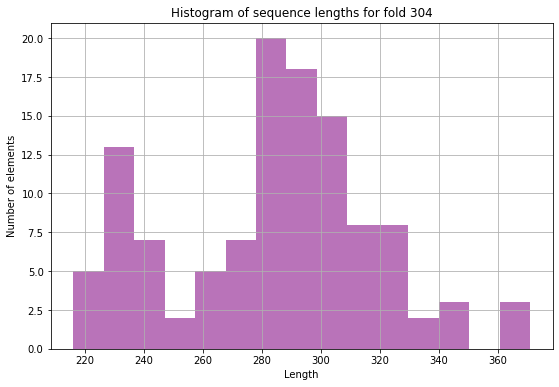

Number of elements in fold = 116


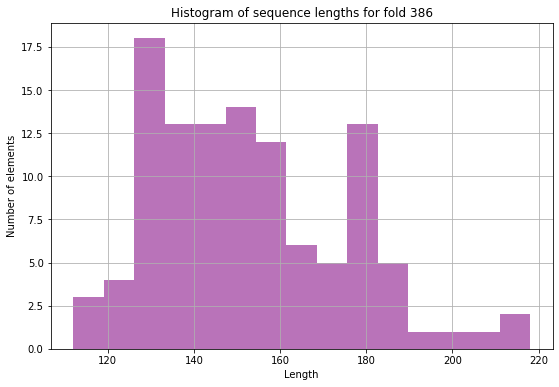

Number of elements in fold = 111


In [ ]:
folds = (6, 51, 52, 61, 130, 262, 274, 304, 386)
for fold in folds:
  length = (seq_data['FOLD'] == fold).sum()
  if 80 <= length and length <= 120:
    print_fold_info(fold, seq_data)

In [ ]:
def scop_seq_to_bert_seq(scop_seq):
    """
    Converts sequences from scop format to prot bert format
    """
    def expand(sequence):
        """
        Expands one sequnce
        """
        return " ".join(sequence.rstrip())
    
    return scop_seq.apply(expand)

In [ ]:
folds = (6, 51, 52, 61, 130, 262, 274, 304, 386)
seq_data = pd.read_csv("/content/drive/MyDrive/m1p/seq_to_fold.csv")
seq_data = seq_data[["FOLD", "sequence"]]
seq_data.head()
preprocessed_data = seq_data[seq_data['FOLD'].isin(folds)]

## Applying BERT to the preprocessed dataset.

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
sequences = preprocessed_data['sequence']
sequences = scop_seq_to_bert_seq(sequences).to_numpy()
target = preprocessed_data['FOLD'].to_numpy()
le = LabelEncoder()
target = le.fit_transform(target) 

In [ ]:
sequences[:5]

array(['K P K E E I K I V E P N G A E K T K L N L N F G V G K L N I S G N E E K L M K G K F I Y S E N E W K P E I K Y E V K D K D G E L E I S Q P G L K S G N V S L N N K R N E W N I N L N E K I P T E I K L S L G T G E F K A D L S K I N L K E L N V G M G V G K V D L D I S G N Y K N N V K V N I E G G V G E A T V Y L P K S I G V K I K A E K G V G A V N A N G F I V E G E N I Y K N S Q Y G K S K N S I E V N I E A G V G A I N I K Q K',
       'D H V K G D G K L T S K K I S V A D Y N E I K V D G V I D F N Y E Q S D D P S T V E V T V D Q N L H P Y V N I E V K D R V L T I A F K G A K V D H F T K F I V K T N S K W L A A A K V S G N A N F M V N S P L T G D E T V I K A N A N S L V Q L K E T V T V G K L D L N V S G S A N M V V N H L E A D K I E C D I D G S G S I T I K K G N A K E G D Y S I V S S G D I H A F G L A V P Q L S C K V T G N G L A E V H A T D N L K A N V V G K G N I R Y K G P T A V Q Q R I I G K G T V E E V',
       'G D G N I T T E N I P V S E Y D C L E L E G G G M V V N Y T Q S D A P E 

In [ ]:
!mkdir /content/drive/MyDrive/m1p/ten_classes_albert/

In [ ]:
for i in tqdm(range(len(sequences))):
  torch.save(torch.tensor(fe(sequences[i])), "/content/drive/MyDrive/m1p/ten_classes_albert/" + str(i) + ".torch")


**Using CNN**:

This section is devoted to applying CNN to the ten-class data.

In [ ]:
class K_max_pooling_1d(nn.Module):
    def __init__(self, k):
        super(K_max_pooling_1d, self).__init__()
        self.k = k

    def forward(self, x):
        #if x.shape[2] < self.k:
        #  return F.pad(input=x, pad=(0, self.k - x.shape[2], 0, 0), 
        #                 mode='constant', value=0)
        top = torch.topk(x, k = self.k)
        return top.values

In [ ]:
 def plot_learning_curves(history):
    '''

    :param history: (dict)
        accuracy and loss for traning and validation
    '''
    # sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('lostt', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Accuracy', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('loss', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    label,
    num_epochs=50
):

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            
            #X_batch = torch.transpose(torch.tensor(fe(train_X[i])), 1, 2).to(device)
            #y_batch = torch.tensor(train_Y[i]).unsqueeze(0).to(device)
                        
            X_batch = torch.transpose(X_batch.squeeze(0), 1, 2).to(device)
            y_batch = y_batch.to(device)

            # Логиты на выходе модели
            logits = model(X_batch)

            # Подсчитываем лосс
            loss = criterion(logits, y_batch.long().to(device))

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()
            
            # Сохраяняем лоссы и точность на трейне
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            X_batch = torch.transpose(X_batch.squeeze(0), 1, 2).to(device)
            y_batch = y_batch.to(device)
            
            #X_batch = torch.transpose(torch.tensor(fe(val_X[i])), 1, 2).to(device)
            #y_batch = torch.tensor(val_Y[i]).unsqueeze(0).to(device)
            
            # Логиты, полученные моделью
            logits = model(X_batch)
            # Лосс на валидации
            loss = criterion(logits, y_batch.long().to(device))

            # Сохраяняем лоссы и точность на валидации
            val_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        if epoch % 5 == 1:
            torch.save(model.state_dict(), 
                   "/content/drive/MyDrive/m1p/two_classes_albert/states/model_state_" + label + "_" + str(epoch))
    return model, history

In [ ]:
# !mkdir /content/drive/MyDrive/m1p/two_classes_albert/states/

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
class FoldDataset(Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, length, labels):
        'Initialization'
        super(Dataset, self).__init__()
        self.length = length
        self.labels = labels
  def __len__(self):
        'Denotes the total number of samples'
        return self.length

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample

        # Load data and get label
        data = torch.load("/content/drive/MyDrive/m1p/ten_classes_albert/" + str(index) + ".torch")
        
        return data, self.labels[index]

In [ ]:
def collate_fn(batch):
  """
  batch: list of individual elements
  """
  max_sz = 0
  for elem in batch:
    max_sz = max(max_sz, elem[0].shape[1])
  target = torch.tensor([elem[1] for elem in batch])
  return torch.cat([F.pad(input=elem[0], pad=(0, 0, 0, max_sz - elem[0].shape[1]), 
                          mode='constant', value=0) for elem in batch]), target

In [ ]:
len(target)

914

In [ ]:
dataset = FoldDataset(len(target), target)
#first_generator = torch.Generator().manual_seed(17)
#dataset, other = random_split(
#    dataset, lengths=(500, 34592 - 500), generator=first_generator)

In [ ]:
val_ratio = 0.2
test_ratio = 0.101
data_len = len(dataset)
test_len = int(data_len * test_ratio)
val_len = int(data_len * val_ratio)
train_len = data_len - val_len - test_len
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(
    dataset, lengths=(train_len, val_len, test_len), generator=generator)
len(train_dataset), len(val_dataset), len(test_dataset)

(640, 182, 92)

In [ ]:
batch_size = 32

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

### Model 5


This is the simpliest model we used for binary classification, the only difference is that the output size of the linear layer is equal to 10.

In [ ]:
model = nn.Sequential()
model.add_module('K_max_pooling', K_max_pooling_1d(30))
# model.add_module('conv1', nn.Conv1d(in_channels=4096, out_channels=256, 
#                                     kernel_size=7, stride=1, padding=3))
model.add_module('relu1', nn.ReLU())
model.add_module('flatteing', nn.Flatten())
model.add_module('FC-layer', nn.Linear(122880, 10))


summary(model, (32, 4096, 300))

Layer (type:depth-idx)                   Output Shape              Param #
├─K_max_pooling_1d: 1-1                  [32, 4096, 30]            --
├─ReLU: 1-2                              [32, 4096, 30]            --
├─Flatten: 1-3                           [32, 122880]              --
├─Linear: 1-4                            [32, 10]                  1,228,810
Total params: 1,228,810
Trainable params: 1,228,810
Non-trainable params: 0
Total mult-adds (M): 39.32
Input size (MB): 157.29
Forward/backward pass size (MB): 0.00
Params size (MB): 4.92
Estimated Total Size (MB): 162.20

Epoch 50 of 50 took 9.012s
  training loss (in-iteration): 	0.718633
  validation loss (in-iteration): 	2.309856
  training accuracy: 			97.34 %
  validation accuracy: 			87.26 %


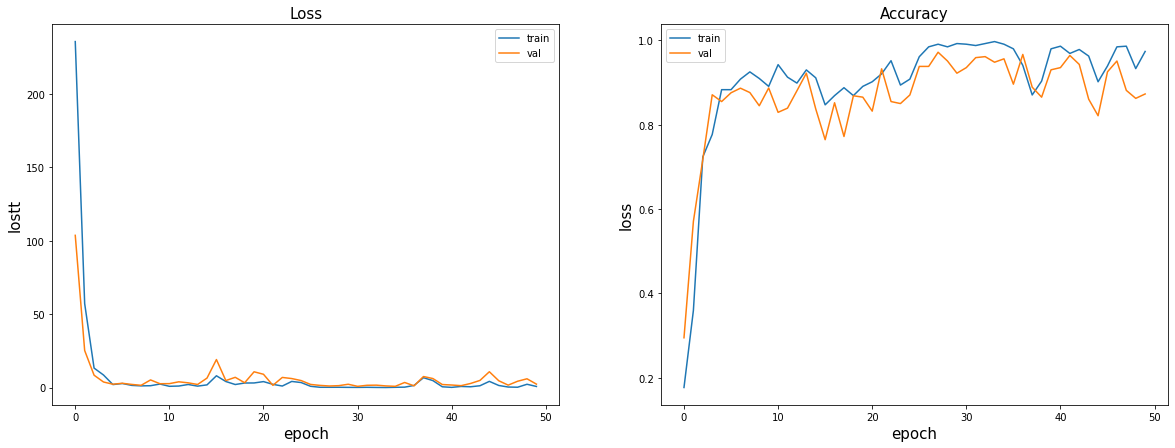

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen,
    "second_exp", num_epochs=50)

In [53]:
test_loss = 0
test_acc = 0
for X_batch, y_batch in test_batch_gen:
    X_batch = torch.transpose(X_batch.squeeze(0), 1, 2).to(device)
    y_batch = y_batch.to(device)
    
    # Логиты, полученные моделью
    logits = model(X_batch)
    # Лосс на валидации
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраяняем лоссы и точность на валидации
    test_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    test_acc += np.mean(y_batch.cpu().numpy() == y_pred)

  # Подсчитываем лоссы и сохраням в "историю"
test_loss /= len(test_batch_gen)
test_acc /= len(test_batch_gen) 
print("TEST ACC =", test_acc * 100)

TEST ACC = 89.28571428571429


**Conclusion:** 89% accuracy score with 10 balanced classes is not a bad result. It shows that we're on a right track. That there is indeed sense in using BERT here. 

### Model 6

What if we increase k in k-max-pooling from 30 to, say, 120? 


In [61]:
model = nn.Sequential()
model.add_module('K_max_pooling', K_max_pooling_1d(120))

model.add_module('relu2', nn.ReLU())
model.add_module('flatteing', nn.Flatten())
model.add_module('FC-layer', nn.Linear(491520, 10))


summary(model, (32, 4096, 300))

Layer (type:depth-idx)                   Output Shape              Param #
├─K_max_pooling_1d: 1-1                  [32, 4096, 120]           --
├─ReLU: 1-2                              [32, 4096, 120]           --
├─Flatten: 1-3                           [32, 491520]              --
├─Linear: 1-4                            [32, 10]                  4,915,210
Total params: 4,915,210
Trainable params: 4,915,210
Non-trainable params: 0
Total mult-adds (M): 157.29
Input size (MB): 157.29
Forward/backward pass size (MB): 0.00
Params size (MB): 19.66
Estimated Total Size (MB): 176.95

Epoch 50 of 50 took 9.446s
  training loss (in-iteration): 	0.000000
  validation loss (in-iteration): 	3.750059
  training accuracy: 			100.00 %
  validation accuracy: 			95.12 %


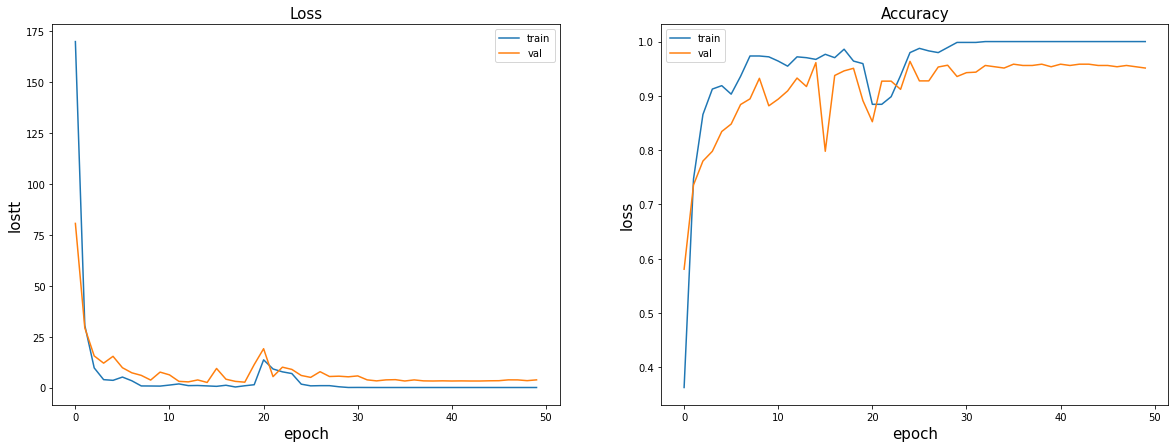

In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen,
    "second_exp", num_epochs=50)

In [63]:
test_loss = 0
test_acc = 0
for X_batch, y_batch in test_batch_gen:
    X_batch = torch.transpose(X_batch.squeeze(0), 1, 2).to(device)
    y_batch = y_batch.to(device)
    
    # Логиты, полученные моделью
    logits = model(X_batch)
    # Лосс на валидации
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраяняем лоссы и точность на валидации
    test_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    test_acc += np.mean(y_batch.cpu().numpy() == y_pred)

  # Подсчитываем лоссы и сохраням в "историю"
test_loss /= len(test_batch_gen)
test_acc /= len(test_batch_gen) 
print("TEST ACC =", test_acc * 100)

TEST ACC = 93.45238095238096


### Model 7

How about k = 60?

In [67]:
model = nn.Sequential()
model.add_module('K_max_pooling', K_max_pooling_1d(60))

model.add_module('relu2', nn.ReLU())
model.add_module('flatteing', nn.Flatten())
model.add_module('FC-layer', nn.Linear(245760, 10))


summary(model, (32, 4096, 300))

Layer (type:depth-idx)                   Output Shape              Param #
├─K_max_pooling_1d: 1-1                  [32, 4096, 60]            --
├─ReLU: 1-2                              [32, 4096, 60]            --
├─Flatten: 1-3                           [32, 245760]              --
├─Linear: 1-4                            [32, 10]                  2,457,610
Total params: 2,457,610
Trainable params: 2,457,610
Non-trainable params: 0
Total mult-adds (M): 78.64
Input size (MB): 157.29
Forward/backward pass size (MB): 0.00
Params size (MB): 9.83
Estimated Total Size (MB): 167.12

Epoch 50 of 50 took 9.420s
  training loss (in-iteration): 	0.000003
  validation loss (in-iteration): 	2.344956
  training accuracy: 			100.00 %
  validation accuracy: 			97.40 %


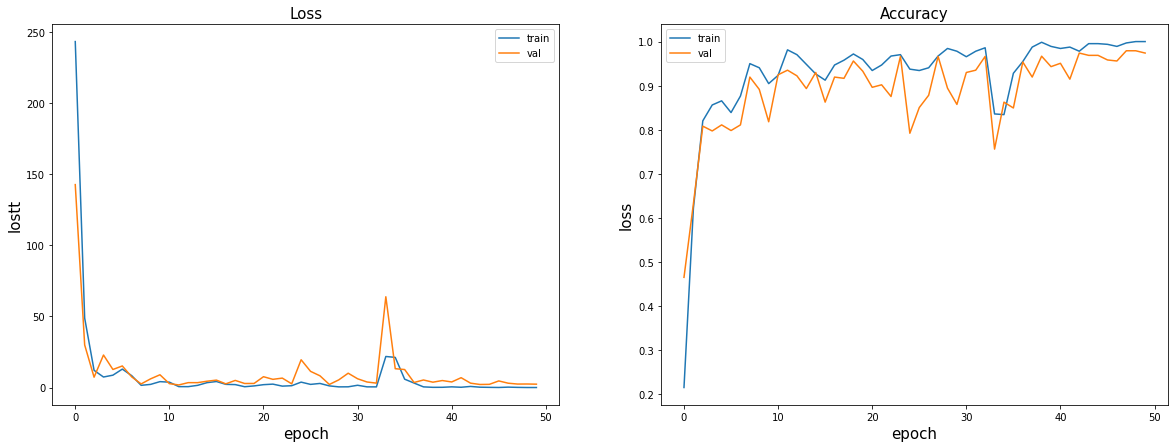

In [68]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen,
    "third_exp", num_epochs=50)

In [70]:
test_loss = 0
test_acc = 0
for X_batch, y_batch in test_batch_gen:
    X_batch = torch.transpose(X_batch.squeeze(0), 1, 2).to(device)
    y_batch = y_batch.to(device)
    
    # Логиты, полученные моделью
    logits = model(X_batch)
    # Лосс на валидации
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраяняем лоссы и точность на валидации
    test_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    test_acc += np.mean(y_batch.cpu().numpy() == y_pred)

  # Подсчитываем лоссы и сохраням в "историю"
test_loss /= len(test_batch_gen)
test_acc /= len(test_batch_gen) 
print("TEST ACC =", test_acc * 100)

TEST ACC = 93.45238095238096


### Model 8 

k = 45

In [73]:
model = nn.Sequential()
model.add_module('K_max_pooling', K_max_pooling_1d(45))

model.add_module('relu2', nn.ReLU())
model.add_module('flatteing', nn.Flatten())
model.add_module('FC-layer', nn.Linear(184320, 10))


summary(model, (32, 4096, 300))

Layer (type:depth-idx)                   Output Shape              Param #
├─K_max_pooling_1d: 1-1                  [32, 4096, 45]            --
├─ReLU: 1-2                              [32, 4096, 45]            --
├─Flatten: 1-3                           [32, 184320]              --
├─Linear: 1-4                            [32, 10]                  1,843,210
Total params: 1,843,210
Trainable params: 1,843,210
Non-trainable params: 0
Total mult-adds (M): 58.98
Input size (MB): 157.29
Forward/backward pass size (MB): 0.00
Params size (MB): 7.37
Estimated Total Size (MB): 164.66

Epoch 50 of 50 took 9.336s
  training loss (in-iteration): 	0.961309
  validation loss (in-iteration): 	2.833259
  training accuracy: 			98.44 %
  validation accuracy: 			95.08 %


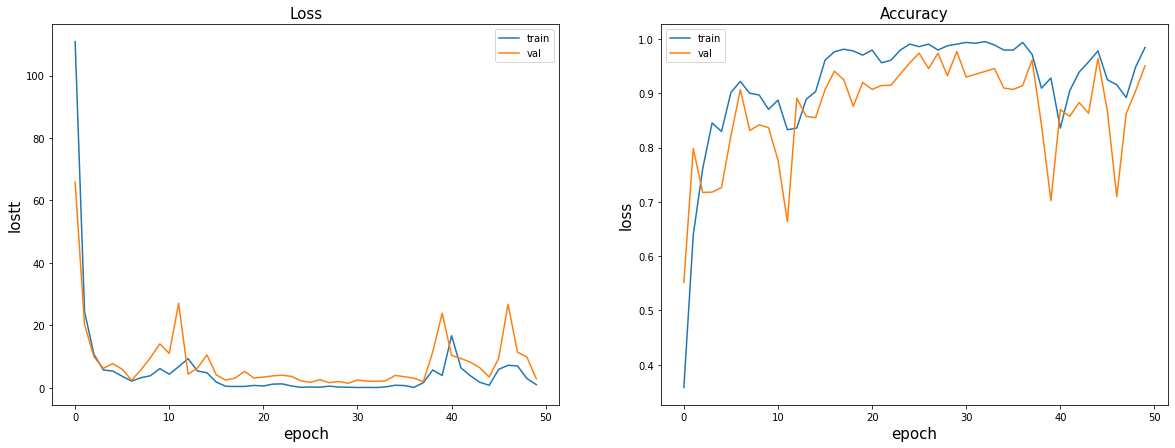

In [74]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen,
    "third_exp", num_epochs=50)

In [75]:
test_loss = 0
test_acc = 0
for X_batch, y_batch in test_batch_gen:
    X_batch = torch.transpose(X_batch.squeeze(0), 1, 2).to(device)
    y_batch = y_batch.to(device)
    
    # Логиты, полученные моделью
    logits = model(X_batch)
    # Лосс на валидации
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраяняем лоссы и точность на валидации
    test_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    test_acc += np.mean(y_batch.cpu().numpy() == y_pred)

  # Подсчитываем лоссы и сохраням в "историю"
test_loss /= len(test_batch_gen)
test_acc /= len(test_batch_gen) 
print("TEST ACC =", test_acc * 100)

TEST ACC = 91.36904761904762
